In [3]:
%matplotlib inline
import logging

import os
import random
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
from glob import glob
import wandb

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader, random_split, Dataset
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor, RandomCrop

from tqdm import tqdm
from sklearn.manifold import TSNE
from PIL import Image
import warnings
warnings.filterwarnings('ignore')


import torchvision
import umap
from cycler import cycler

import pytorch_metric_learning
import pytorch_metric_learning.utils.logging_presets as logging_presets
from pytorch_metric_learning import losses, miners, samplers, testers, trainers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

logging.getLogger().setLevel(logging.INFO)
logging.info("VERSION %s" % pytorch_metric_learning.__version__)

/var/scratch/mxiao/anaconda3/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
2023-06-12 10:32:35.463290: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
INFO:root:VERSION 2.1.2


In [4]:
path = '/var/scratch/mxiao/data/'
os.chdir(path)

In [5]:
# Config device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [11]:
!ls example_tensorboard

events.out.tfevents.1686512361.node434.5225.2


In [12]:
!ls example_tensorboard

events.out.tfevents.1686512361.node434.5225.2


In [91]:
df = pd.read_csv('example_logs/accuracies_normalized_GlobalEmbeddingSpaceTester_level_0_VAL_vs_self.csv')
df

~iteration~  epoch  AMI_level0  NMI_level0  mean_average_precision_level0  \
0             1      1    0.592729    0.792856                       0.367768   
1             2      2    0.603993    0.798400                       0.375140   
2             3      3    0.614119    0.803500                       0.388438   
3             4      4    0.619673    0.806454                       0.397663   
4             5      5    0.631556    0.812288                       0.405489   
5             6      6    0.639386    0.816153                       0.415741   
6             7      7    0.639812    0.816509                       0.416787   
7             8      8    0.645697    0.819478                       0.422256   
8             9      9    0.647088    0.820273                       0.431343   
9            10     10    0.656808    0.824922                       0.438144   
10           11     11    0.665065    0.829150                       0.441910   
11           12     12    0.661432    0.827211                       0.448032   
12           13     13    0.668017    0.830639                       0.443723   
13           14     14    0.664176    0.828819                       0.448850   

    mean_average_precision_at_r_level0  mean_reciprocal_rank_level0  \
0                             0.311674                     0.783980   
1                             0.318465                     0.789664   
2                             0.330273                     0.803395   
3                             0.339016                     0.802306   
4                             0.345434                     0.810035   
5                             0.355752                     0.818888   
6                             0.356169                     0.819472   
7                             0.360920                     0.823091   
8                             0.368917                     0.827349   
9                             0.374857                     0.833254   
10                            0.377982                     0.836037   
11                            0.384076                     0.838160   
12                            0.379465                     0.835065   
13                            0.384522                     0.837326   

    precision_at_1_level0  r_precision_level0  best_epoch  best_accuracy  
0                0.715153            0.396226           1       0.311674  
1                0.723061            0.401865           2       0.318465  
2                0.739155            0.413440           3       0.330273  
3                0.738097            0.421367           4       0.339016  
4                0.748121            0.428473           5       0.345434  
5                0.759370            0.436900           6       0.355752  
6                0.759147            0.437796           7       0.356169  
7                0.763992            0.442535           8       0.360920  
8                0.770285            0.448714           9       0.368917  
9                0.776577            0.454781          10       0.374857  
10               0.781478            0.457943          11       0.377982  
11               0.783984            0.463657          12       0.384076  
12               0.778081            0.459885          12       0.384076  
13               0.782313            0.464213          14       0.384522

In [92]:
105/5

21.0

In [64]:
21*32

672

In [81]:
!ls PML_v2

classifier_1.pth		embedder_optimizer_best1.pth
classifier_5.pth		embedder_optimizer_best5.pth
classifier_best1.pth		metric_loss_1.pth
classifier_best5.pth		metric_loss_5.pth
classifier_loss_1.pth		metric_loss_best1.pth
classifier_loss_5.pth		metric_loss_best5.pth
classifier_loss_best1.pth	trunk_1.pth
classifier_loss_best5.pth	trunk_5.pth
classifier_optimizer_1.pth	trunk_best1.pth
classifier_optimizer_5.pth	trunk_best5.pth
classifier_optimizer_best1.pth	trunk_optimizer_1.pth
classifier_optimizer_best5.pth	trunk_optimizer_5.pth
embedder_1.pth			trunk_optimizer_best1.pth
embedder_5.pth			trunk_optimizer_best5.pth
embedder_best1.pth		tuple_miner_1.pth
embedder_best5.pth		tuple_miner_5.pth
embedder_optimizer_1.pth	tuple_miner_best1.pth
embedder_optimizer_5.pth	tuple_miner_best5.pth


In [1]:
import torch
torch.cuda.empty_cache()

In [13]:
# Set the image transforms
normalize = transforms.Normalize(mean=[0.6195012,0.6195012,0.6195012], std=[0.3307451,0.3307451,0.3307451])

train_transform = transforms.Compose([
#         transforms.RandomRotation(10),      # rotate +/- 10 degrees
#         transforms.RandomHorizontalFlip(),  # reverse 50% of images
#         transforms.RandomVerticalFlip(p=0.5),
#         transforms.Resize(224),             # resize shortest side to 224 pixels
#         transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.RandomCrop(size=(224,224),pad_if_needed=True), 
        transforms.ToTensor(),
        normalize
    ])

test_transform = transforms.Compose([
        transforms.RandomCrop((224,224),pad_if_needed=True),
        transforms.ToTensor(),
        normalize
    ])

In [14]:
batch_size = 32

dataset1 = datasets.ImageFolder(root=("model/train"),transform=train_transform)
dataset2 = datasets.ImageFolder(root=("model/test"),transform=test_transform)

class_dict = {i: class_name for i, class_name in enumerate(dataset1.classes)}

In [15]:
class MLP(nn.Module):
    # layer_sizes[0] is the dimension of the input
    # layer_sizes[-1] is the dimension of the output
    def __init__(self, layer_sizes, final_relu=False):
        super().__init__()
        layer_list = []
        layer_sizes = [int(x) for x in layer_sizes]
        num_layers = len(layer_sizes) - 1
        final_relu_layer = num_layers if final_relu else num_layers - 1
        for i in range(len(layer_sizes) - 1):
            input_size = layer_sizes[i]
            curr_size = layer_sizes[i + 1]
            if i < final_relu_layer:
                layer_list.append(nn.ReLU(inplace=False))
            layer_list.append(nn.Linear(input_size, curr_size))
        self.net = nn.Sequential(*layer_list)
        self.last_linear = self.net[-1]

    def forward(self, x):
        return self.net(x)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set trunk model and replace the softmax layer with an identity function
trunk = torchvision.models.resnet50(pretrained=True).to(device)
trunk_output_size = trunk.fc.in_features
trunk.fc = nn.Identity()
trunk = torch.nn.DataParallel(trunk.to(device))

# Set embedder model. This takes in the output of the trunk and outputs 64 dimensional embeddings
embedder = torch.nn.DataParallel(MLP([trunk_output_size, 1024]).to(device))

# Set the classifier. The classifier will take the embeddings and output a 50 dimensional vector.
# (Our training set will consist of the first 50 classes of the CIFAR100 dataset.)
# We'll specify the classification loss further down in the code.
classifier = torch.nn.DataParallel(MLP([1024, len(class_dict)])).to(device)

# Set optimizers
trunk_optimizer = torch.optim.Adam(trunk.parameters(), lr=0.00001, weight_decay=0.0001)
embedder_optimizer = torch.optim.Adam(
    embedder.parameters(), lr=0.0001, weight_decay=0.0001
)
classifier_optimizer = torch.optim.Adam(
    classifier.parameters(), lr=0.0001, weight_decay=0.0001
)

In [2]:
# train_loader = torch.utils.data.DataLoader(dataset1, batch_size=batch_size, shuffle=True, num_workers=4)
# test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size, shuffle=False, num_workers=4)
torch.cuda.is_available()

False

In [36]:
# Set the loss function
loss = losses.TripletMarginLoss(margin=0.1)

# Set the classification loss:
classification_loss = torch.nn.CrossEntropyLoss()

# Set the mining function
miner = miners.MultiSimilarityMiner(epsilon=0.1)

# miner = miners.TripletMarginMiner(
#     margin=0.2, distance=distance, type_of_triplets="hard"
# )

# Set the dataloader sampler
sampler = samplers.MPerClassSampler(
    dataset1.targets, m=4, length_before_new_iter=len(dataset1)
)

# Set other training parameters
num_epochs = 20

# Package the above stuff into dictionaries.
models = {"trunk": trunk, "embedder": embedder, "classifier": classifier}
optimizers = {
    "trunk_optimizer": trunk_optimizer,
    "embedder_optimizer": embedder_optimizer,
    "classifier_optimizer": classifier_optimizer,
}
loss_funcs = {"metric_loss": loss, "classifier_loss": classification_loss}
mining_funcs = {"tuple_miner": miner}

# We can specify loss weights if we want to. This is optional
loss_weights = {"metric_loss": 1, "classifier_loss": 0.5}

In [83]:
# Remove logs if you want to train with new parameters
!rm -rf example_logs/ example_saved_models/ example_tensorboard/

In [ ]:
record_keeper, _, _ = logging_presets.get_record_keeper(
    "example_logs", "example_tensorboard"
)
hooks = logging_presets.get_hook_container(record_keeper)
dataset_dict = {"val": dataset2}
model_folder = "PML_v2"


def visualizer_hook(umapper, umap_embeddings, labels, split_name, keyname, *args):
    logging.info(
        "UMAP plot for the {} split and label set {}".format(split_name, keyname)
    )
    label_set = np.unique(labels)
    num_classes = len(label_set)
    plt.figure(figsize=(20, 15))
    plt.gca().set_prop_cycle(
        cycler(
            "color", [plt.cm.nipy_spectral(i) for i in np.linspace(0, 0.9, num_classes)]
        )
    )
    for i in range(num_classes):
        idx = labels == label_set[i]
        plt.plot(umap_embeddings[idx, 0], umap_embeddings[idx, 1], ".", markersize=1)
    plt.show()


# Create the tester
tester = testers.GlobalEmbeddingSpaceTester(
    end_of_testing_hook=hooks.end_of_testing_hook,
    visualizer=umap.UMAP(),
    visualizer_hook=visualizer_hook,
    dataloader_num_workers=4,
    accuracy_calculator=AccuracyCalculator(k="max_bin_count"),
)

end_of_epoch_hook = hooks.end_of_epoch_hook(
    tester, dataset_dict, model_folder, test_interval=1, patience=1
)

In [85]:
trainer = trainers.TrainWithClassifier(
    models,
    optimizers,
    batch_size,
    loss_funcs,
    dataset1,
    mining_funcs=mining_funcs,
    sampler=sampler,
    dataloader_num_workers=4,
    loss_weights=loss_weights,
    end_of_iteration_hook=hooks.end_of_iteration_hook,
    end_of_epoch_hook=end_of_epoch_hook,
)

In [25]:
# %load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir example_tensorboard
# %tensorboard --logdir=./logs --host localhost

Reusing TensorBoard on port 6006 (pid 28249), started 0:14:06 ago. (Use '!kill 28249' to kill it.)

INFO:PML:Initializing dataloader
INFO:PML:Initializing dataloader iterator
INFO:PML:Done creating dataloader iterator
INFO:PML:TRAINING EPOCH 1
total_loss=0.96908: 100%|███████████████████████████████████████████████████████████| 1028/1028 [05:44<00:00,  2.98it/s]
INFO:PML:Evaluating epoch 1
INFO:PML:Getting embeddings for the val split
100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:01<00:00,  9.19it/s]
INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


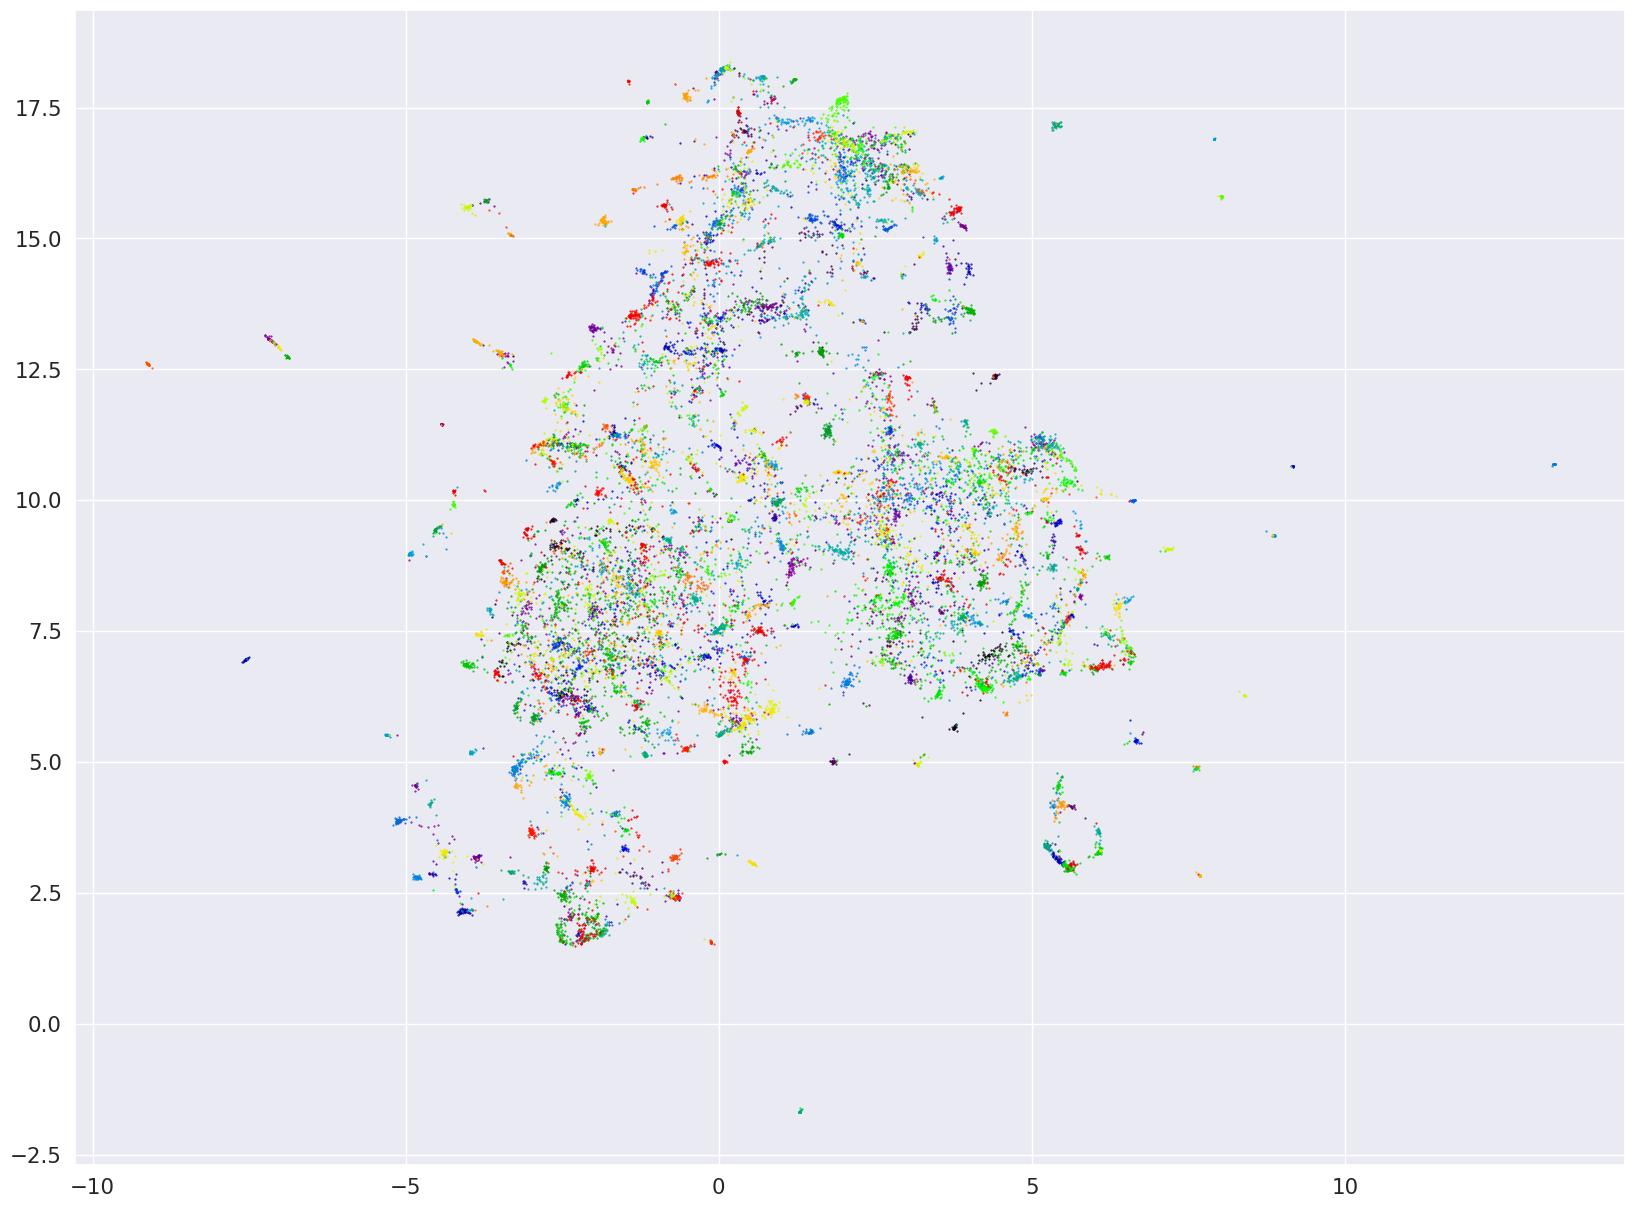

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=95
INFO:PML:embedding dimensionality is 1024
INFO:PML:running k-means clustering with k=748
INFO:PML:embedding dimensionality is 1024
WARNING clustering 17958 points to 748 centroids: please provide at least 29172 training points
INFO:PML:New best accuracy! 0.3116742312677874
INFO:PML:TRAINING EPOCH 2
total_loss=0.80507: 100%|███████████████████████████████████████████████████████████| 1028/1028 [05:52<00:00,  2.92it/s]
INFO:PML:Evaluating epoch 2
INFO:PML:Getting embeddings for the val split
100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:01<00:00,  9.18it/s]
INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


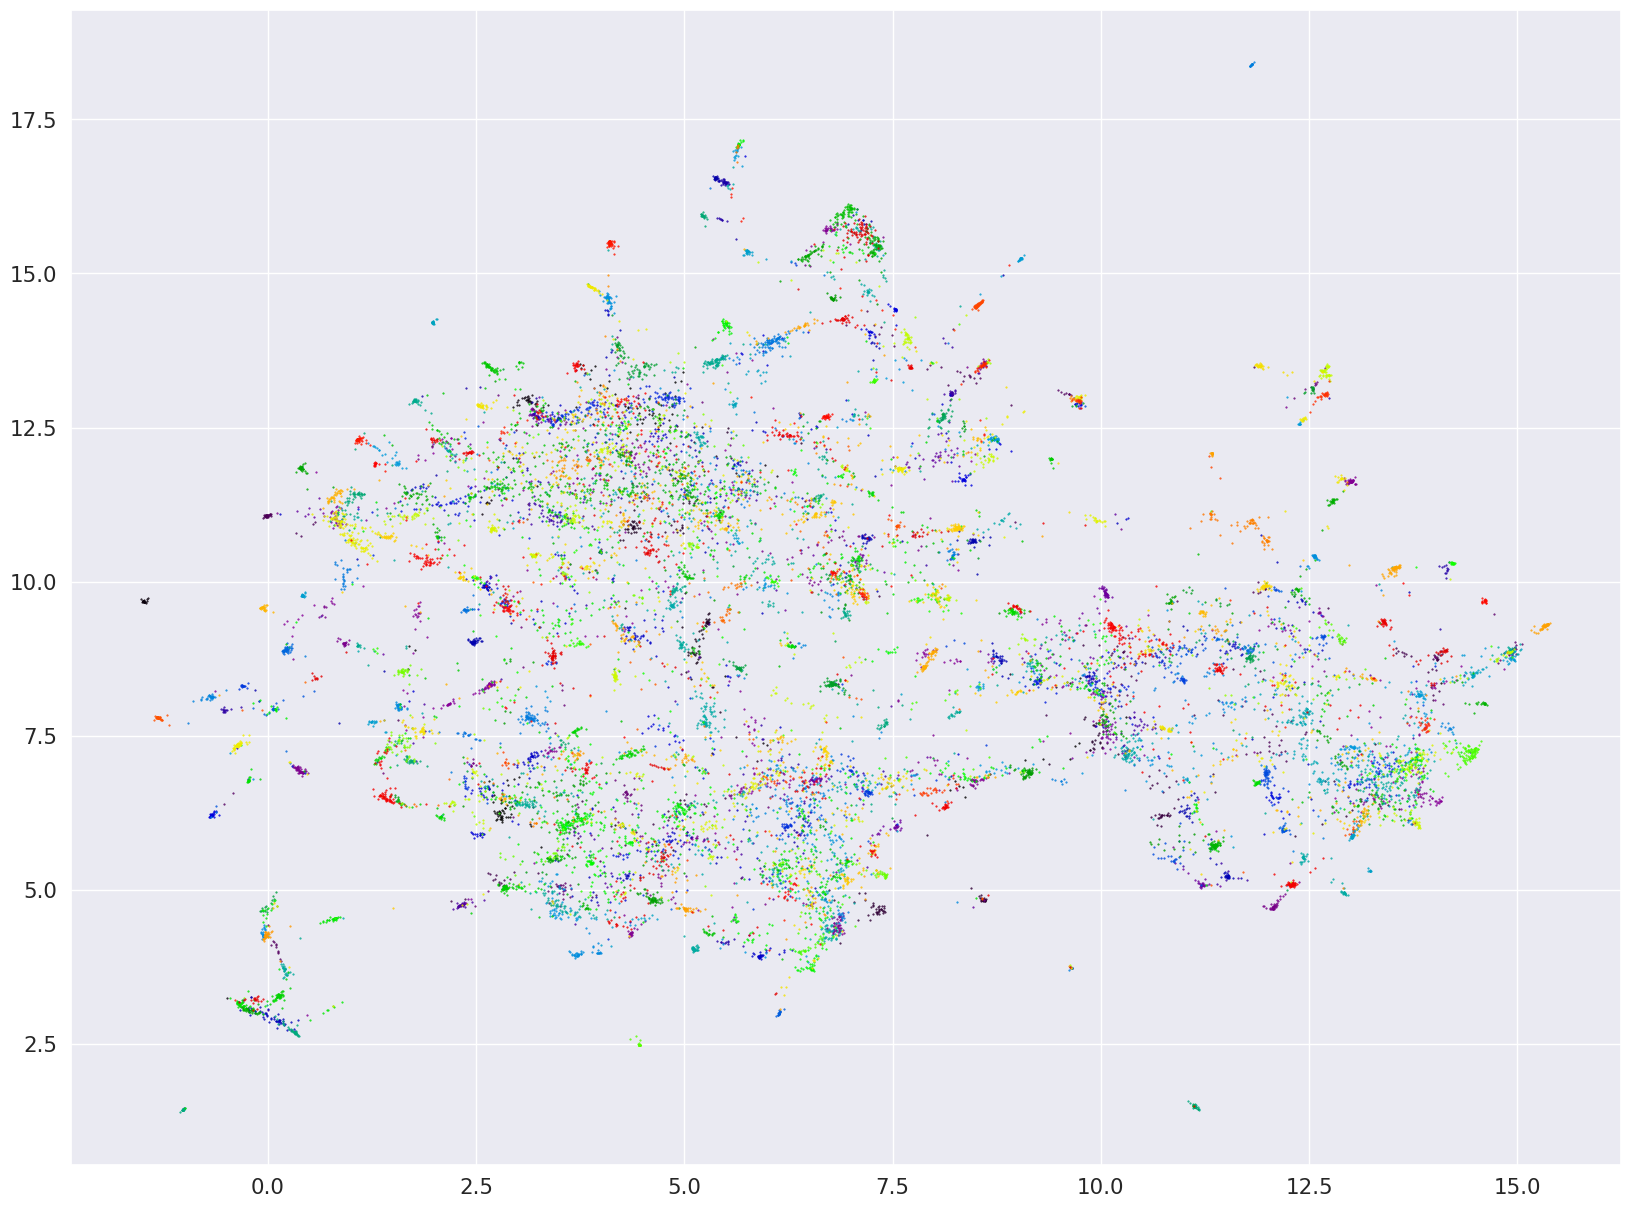

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=95
INFO:PML:embedding dimensionality is 1024
INFO:PML:running k-means clustering with k=748
INFO:PML:embedding dimensionality is 1024
WARNING clustering 17958 points to 748 centroids: please provide at least 29172 training points
INFO:PML:New best accuracy! 0.31846473704268613
INFO:PML:TRAINING EPOCH 3
total_loss=1.49214: 100%|███████████████████████████████████████████████████████████| 1028/1028 [05:52<00:00,  2.92it/s]
INFO:PML:Evaluating epoch 3
INFO:PML:Getting embeddings for the val split
100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:01<00:00,  9.16it/s]
INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


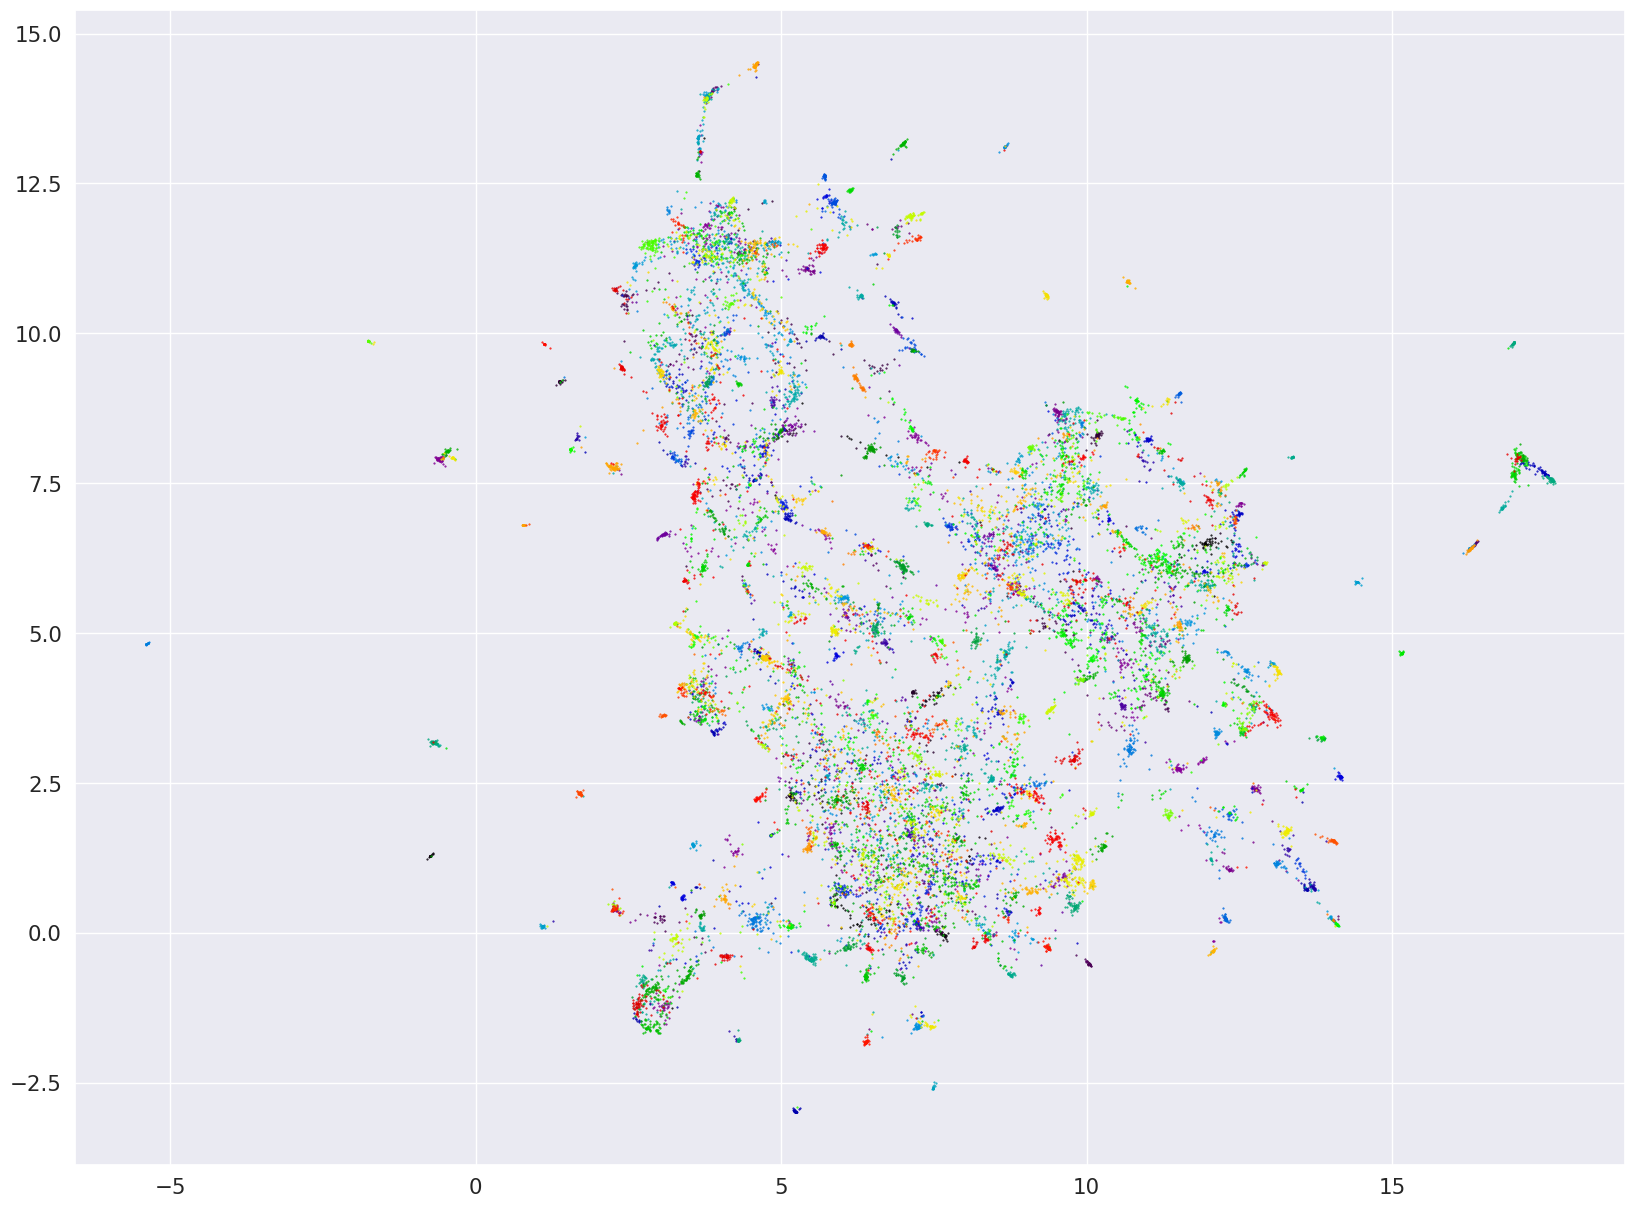

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=95
INFO:PML:embedding dimensionality is 1024
INFO:PML:running k-means clustering with k=748
INFO:PML:embedding dimensionality is 1024
WARNING clustering 17958 points to 748 centroids: please provide at least 29172 training points
INFO:PML:New best accuracy! 0.33027300241247165
INFO:PML:TRAINING EPOCH 4
total_loss=0.85506: 100%|███████████████████████████████████████████████████████████| 1028/1028 [05:53<00:00,  2.91it/s]
INFO:PML:Evaluating epoch 4
INFO:PML:Getting embeddings for the val split
100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:01<00:00,  9.14it/s]
INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


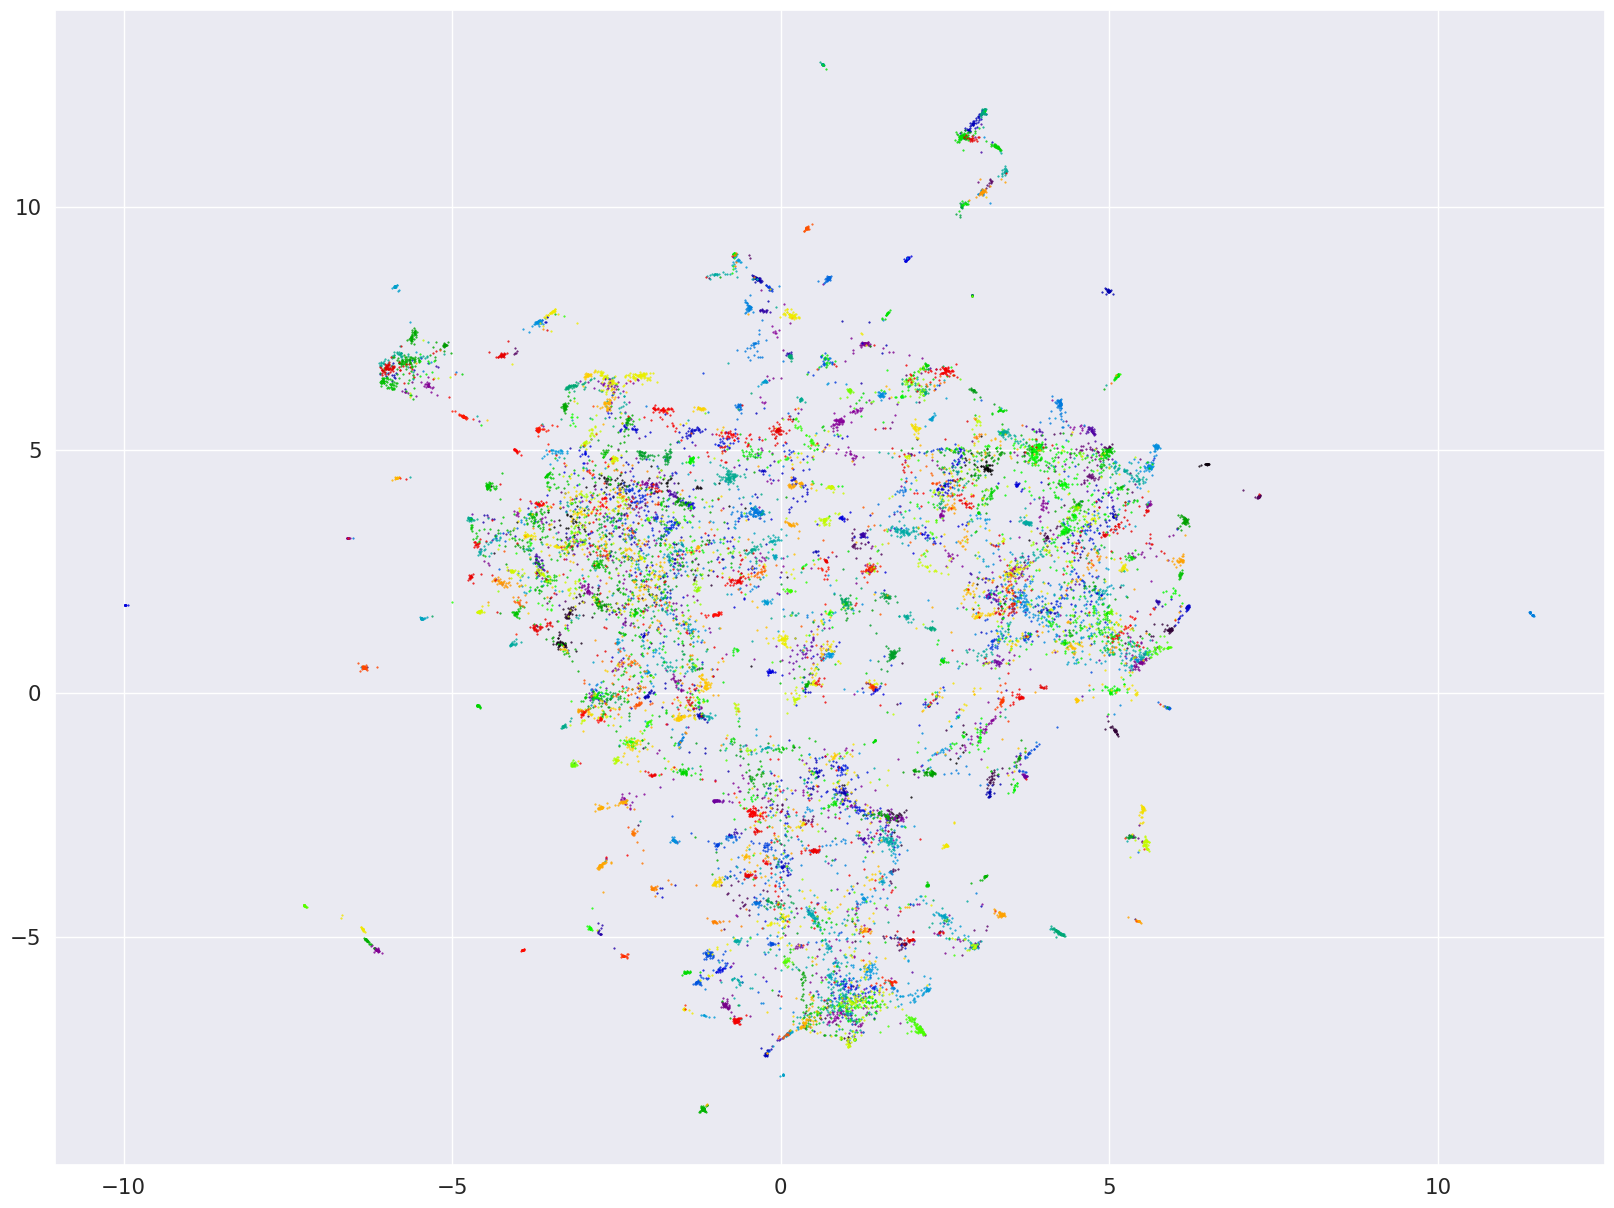

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=95
INFO:PML:embedding dimensionality is 1024
INFO:PML:running k-means clustering with k=748
INFO:PML:embedding dimensionality is 1024
WARNING clustering 17958 points to 748 centroids: please provide at least 29172 training points
INFO:PML:New best accuracy! 0.3390156242527884
INFO:PML:TRAINING EPOCH 5
total_loss=0.61766: 100%|███████████████████████████████████████████████████████████| 1028/1028 [05:52<00:00,  2.92it/s]
INFO:PML:Evaluating epoch 5
INFO:PML:Getting embeddings for the val split
100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:01<00:00,  9.17it/s]
INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


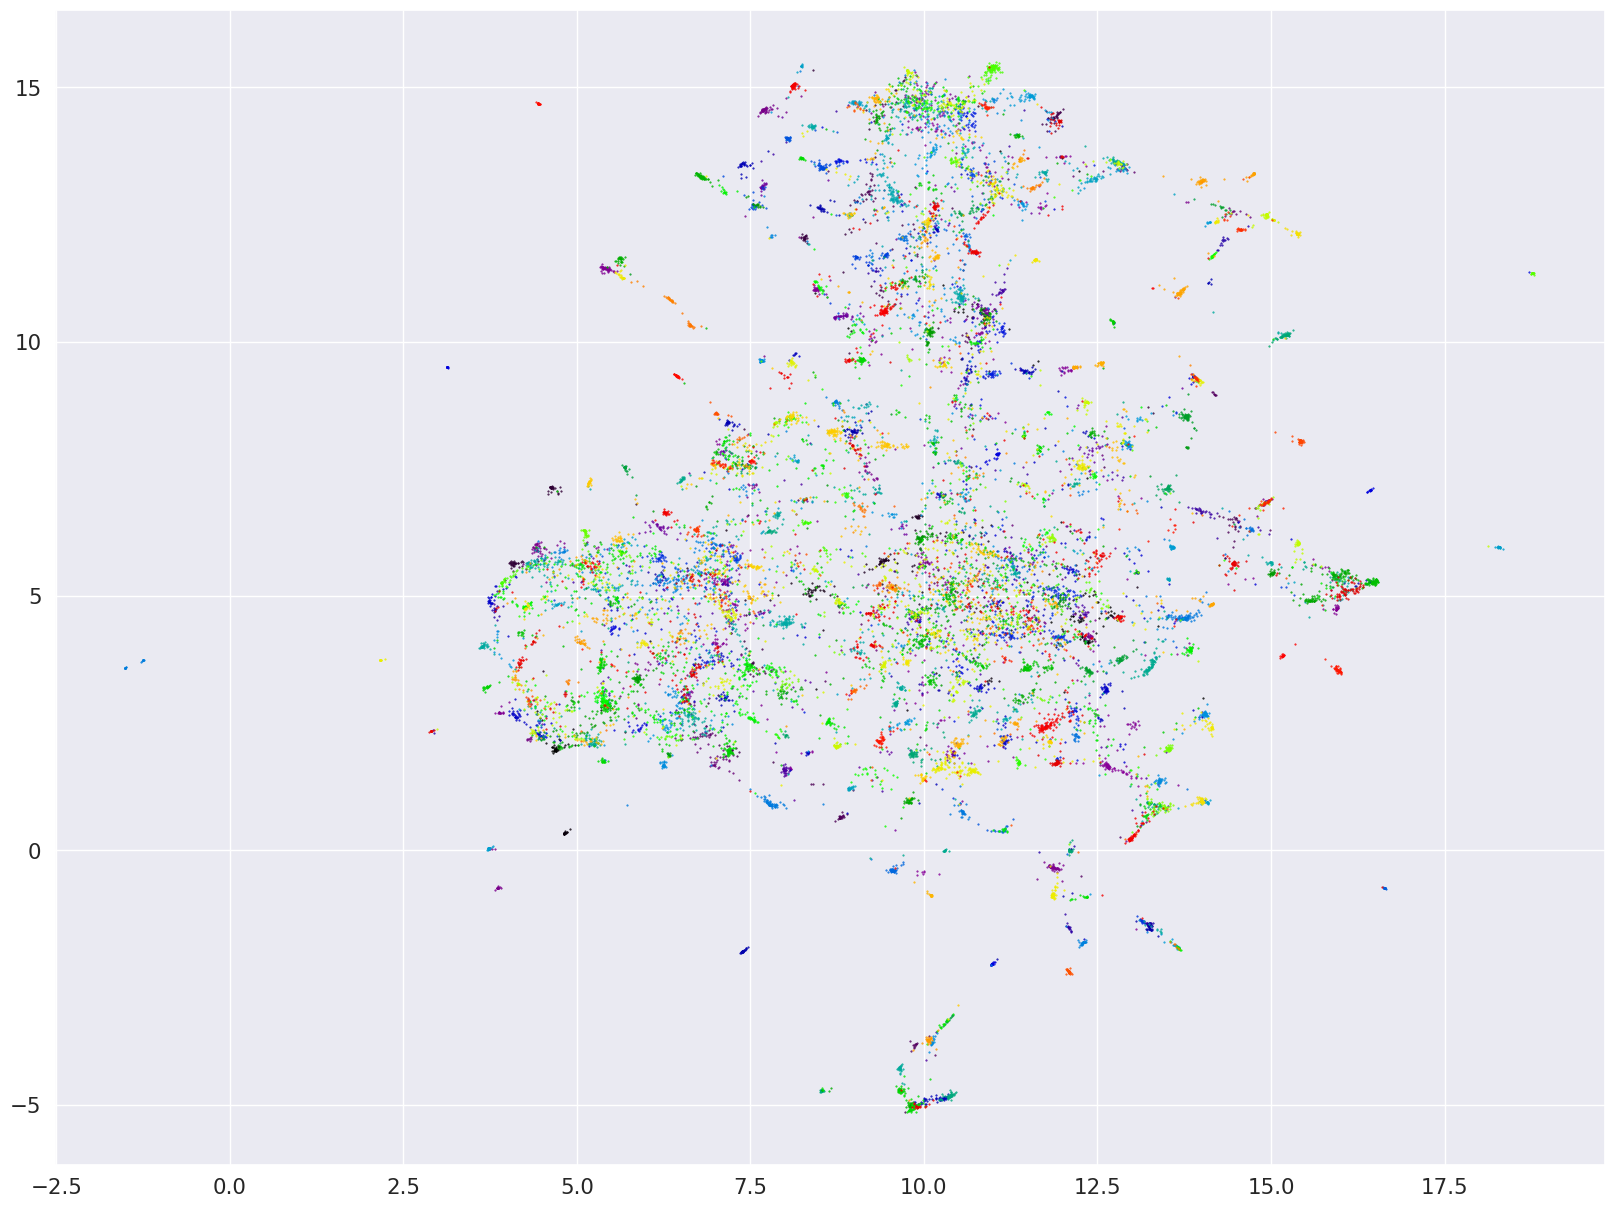

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=95
INFO:PML:embedding dimensionality is 1024
INFO:PML:running k-means clustering with k=748
INFO:PML:embedding dimensionality is 1024
WARNING clustering 17958 points to 748 centroids: please provide at least 29172 training points
INFO:PML:New best accuracy! 0.34543361682846824
INFO:PML:TRAINING EPOCH 6
total_loss=0.89538: 100%|███████████████████████████████████████████████████████████| 1028/1028 [05:53<00:00,  2.91it/s]
INFO:PML:Evaluating epoch 6
INFO:PML:Getting embeddings for the val split
100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:01<00:00,  9.13it/s]
INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


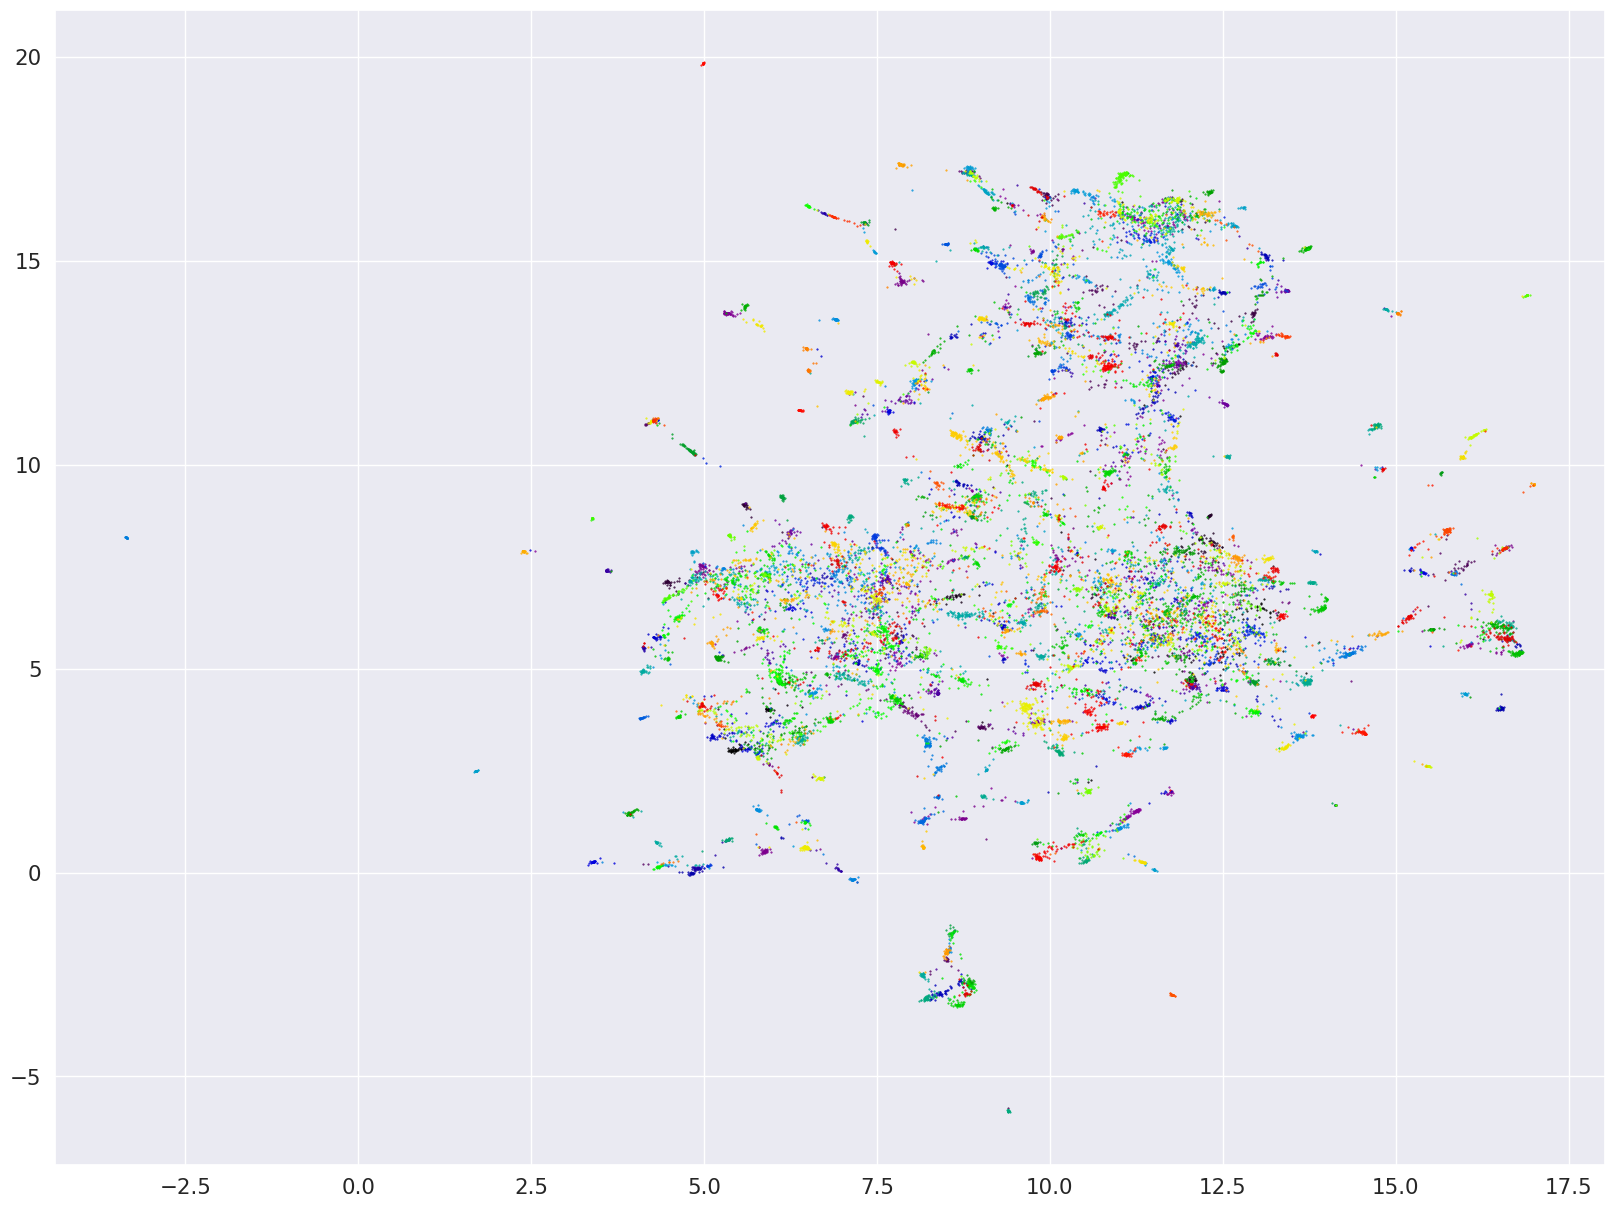

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=95
INFO:PML:embedding dimensionality is 1024
INFO:PML:running k-means clustering with k=748
INFO:PML:embedding dimensionality is 1024
WARNING clustering 17958 points to 748 centroids: please provide at least 29172 training points
INFO:PML:New best accuracy! 0.35575170000396583
INFO:PML:TRAINING EPOCH 7
total_loss=0.77295: 100%|███████████████████████████████████████████████████████████| 1028/1028 [05:53<00:00,  2.91it/s]
INFO:PML:Evaluating epoch 7
INFO:PML:Getting embeddings for the val split
100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:01<00:00,  9.21it/s]
INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


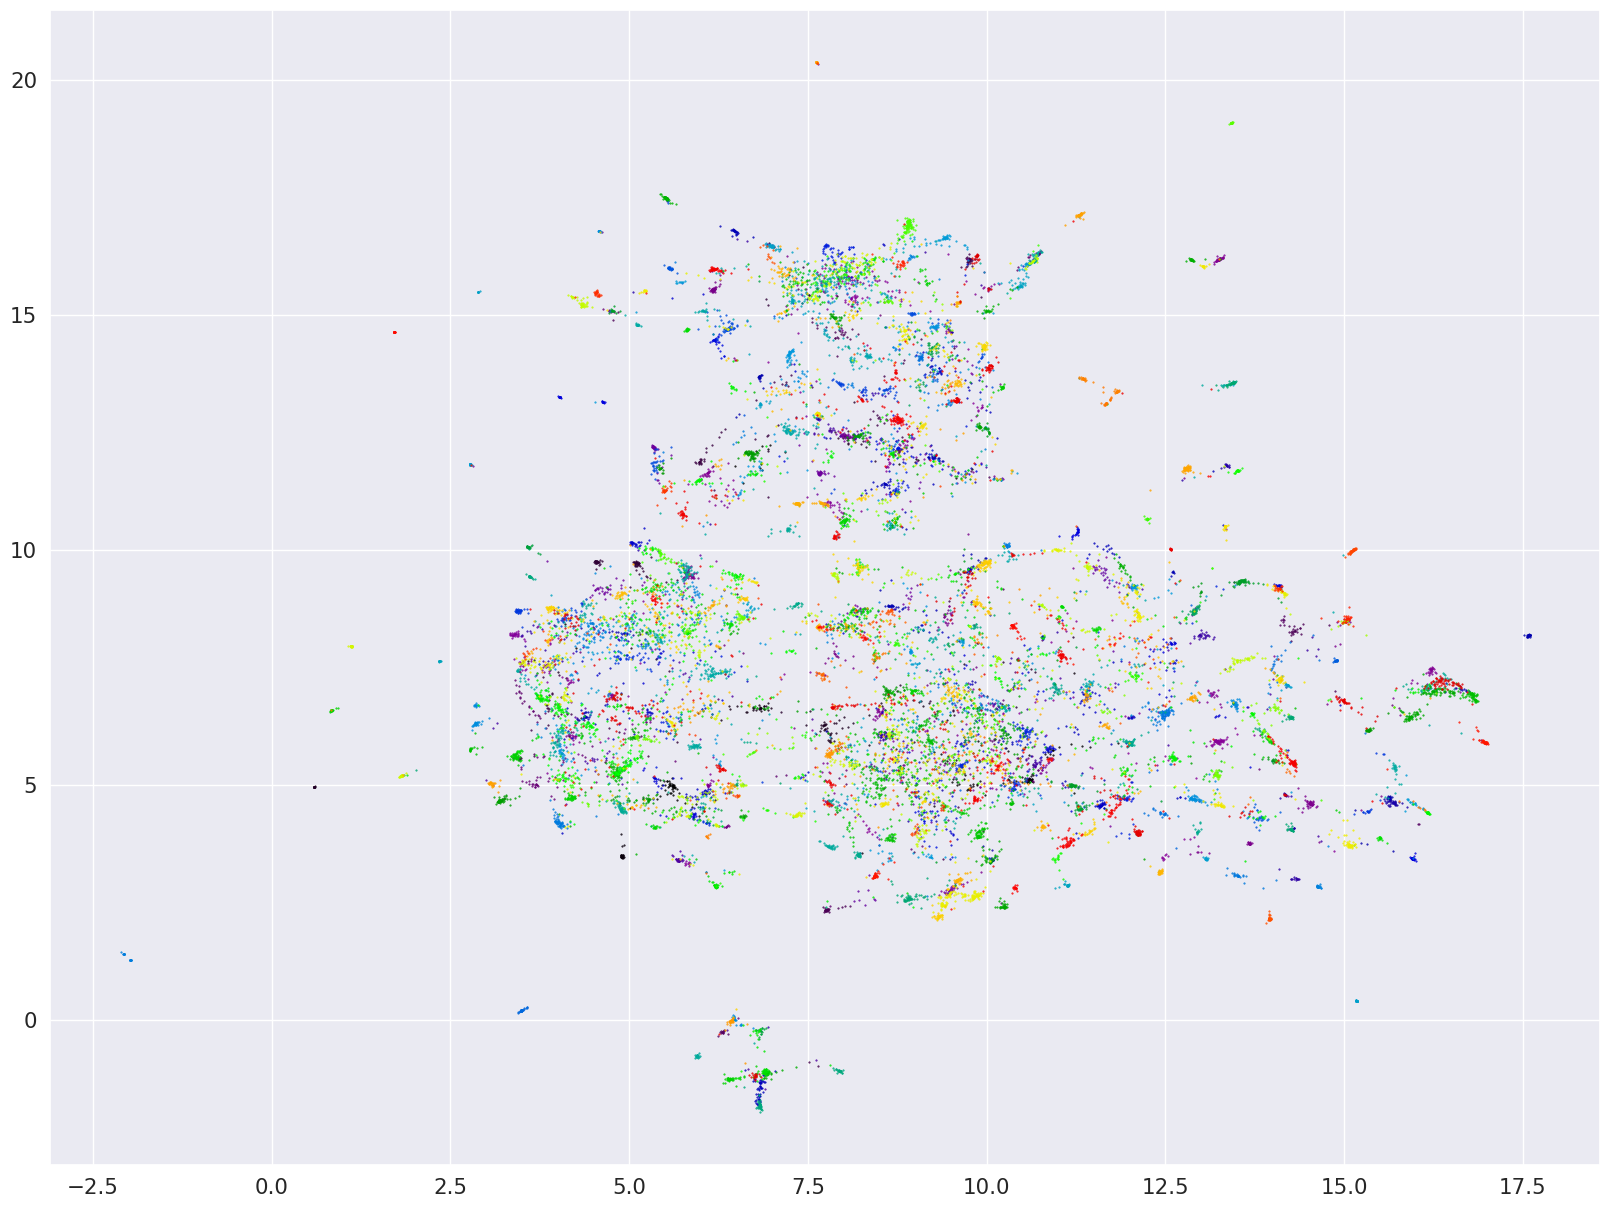

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=95
INFO:PML:embedding dimensionality is 1024
INFO:PML:running k-means clustering with k=748
INFO:PML:embedding dimensionality is 1024
WARNING clustering 17958 points to 748 centroids: please provide at least 29172 training points
INFO:PML:New best accuracy! 0.3561689554284241
INFO:PML:TRAINING EPOCH 8
total_loss=0.75784: 100%|███████████████████████████████████████████████████████████| 1028/1028 [05:53<00:00,  2.91it/s]
INFO:PML:Evaluating epoch 8
INFO:PML:Getting embeddings for the val split
100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:01<00:00,  9.18it/s]
INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


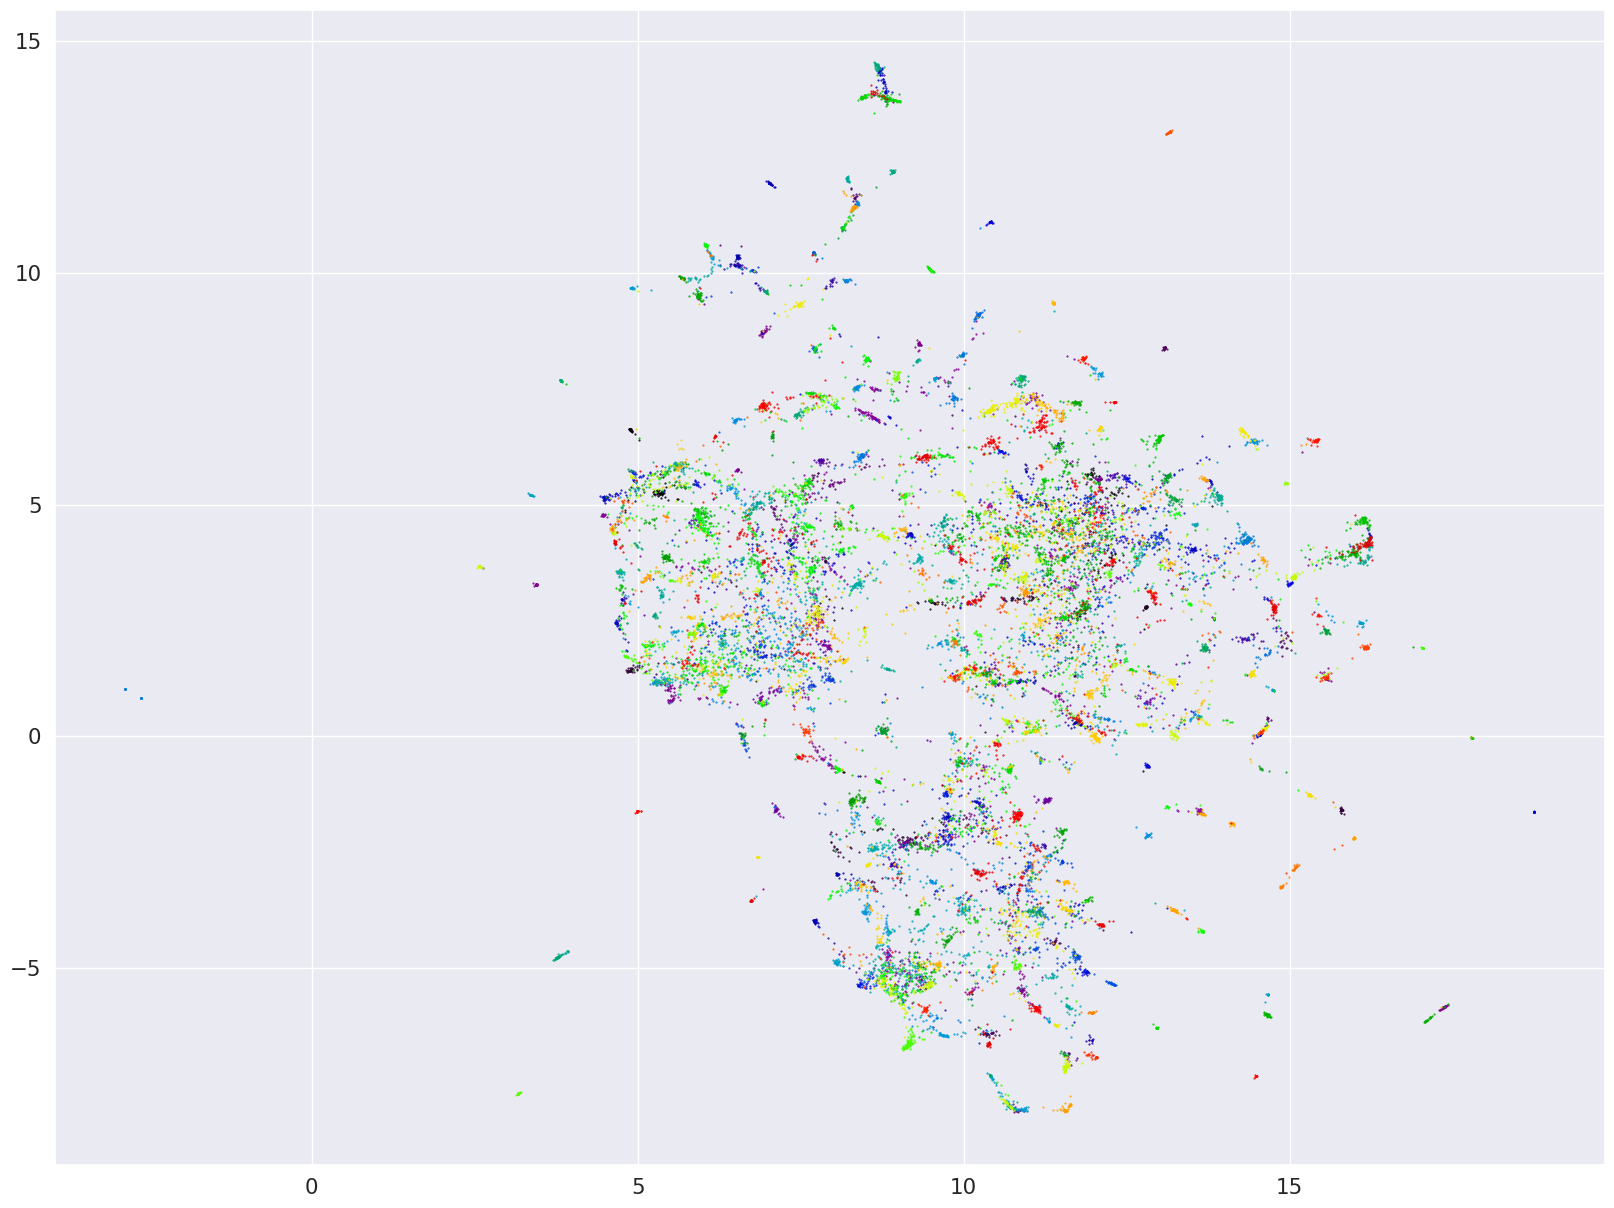

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=95
INFO:PML:embedding dimensionality is 1024
INFO:PML:running k-means clustering with k=748
INFO:PML:embedding dimensionality is 1024
WARNING clustering 17958 points to 748 centroids: please provide at least 29172 training points
INFO:PML:New best accuracy! 0.36092024110790016
INFO:PML:TRAINING EPOCH 9
total_loss=0.84752: 100%|███████████████████████████████████████████████████████████| 1028/1028 [05:53<00:00,  2.91it/s]
INFO:PML:Evaluating epoch 9
INFO:PML:Getting embeddings for the val split
100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:01<00:00,  9.16it/s]
INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


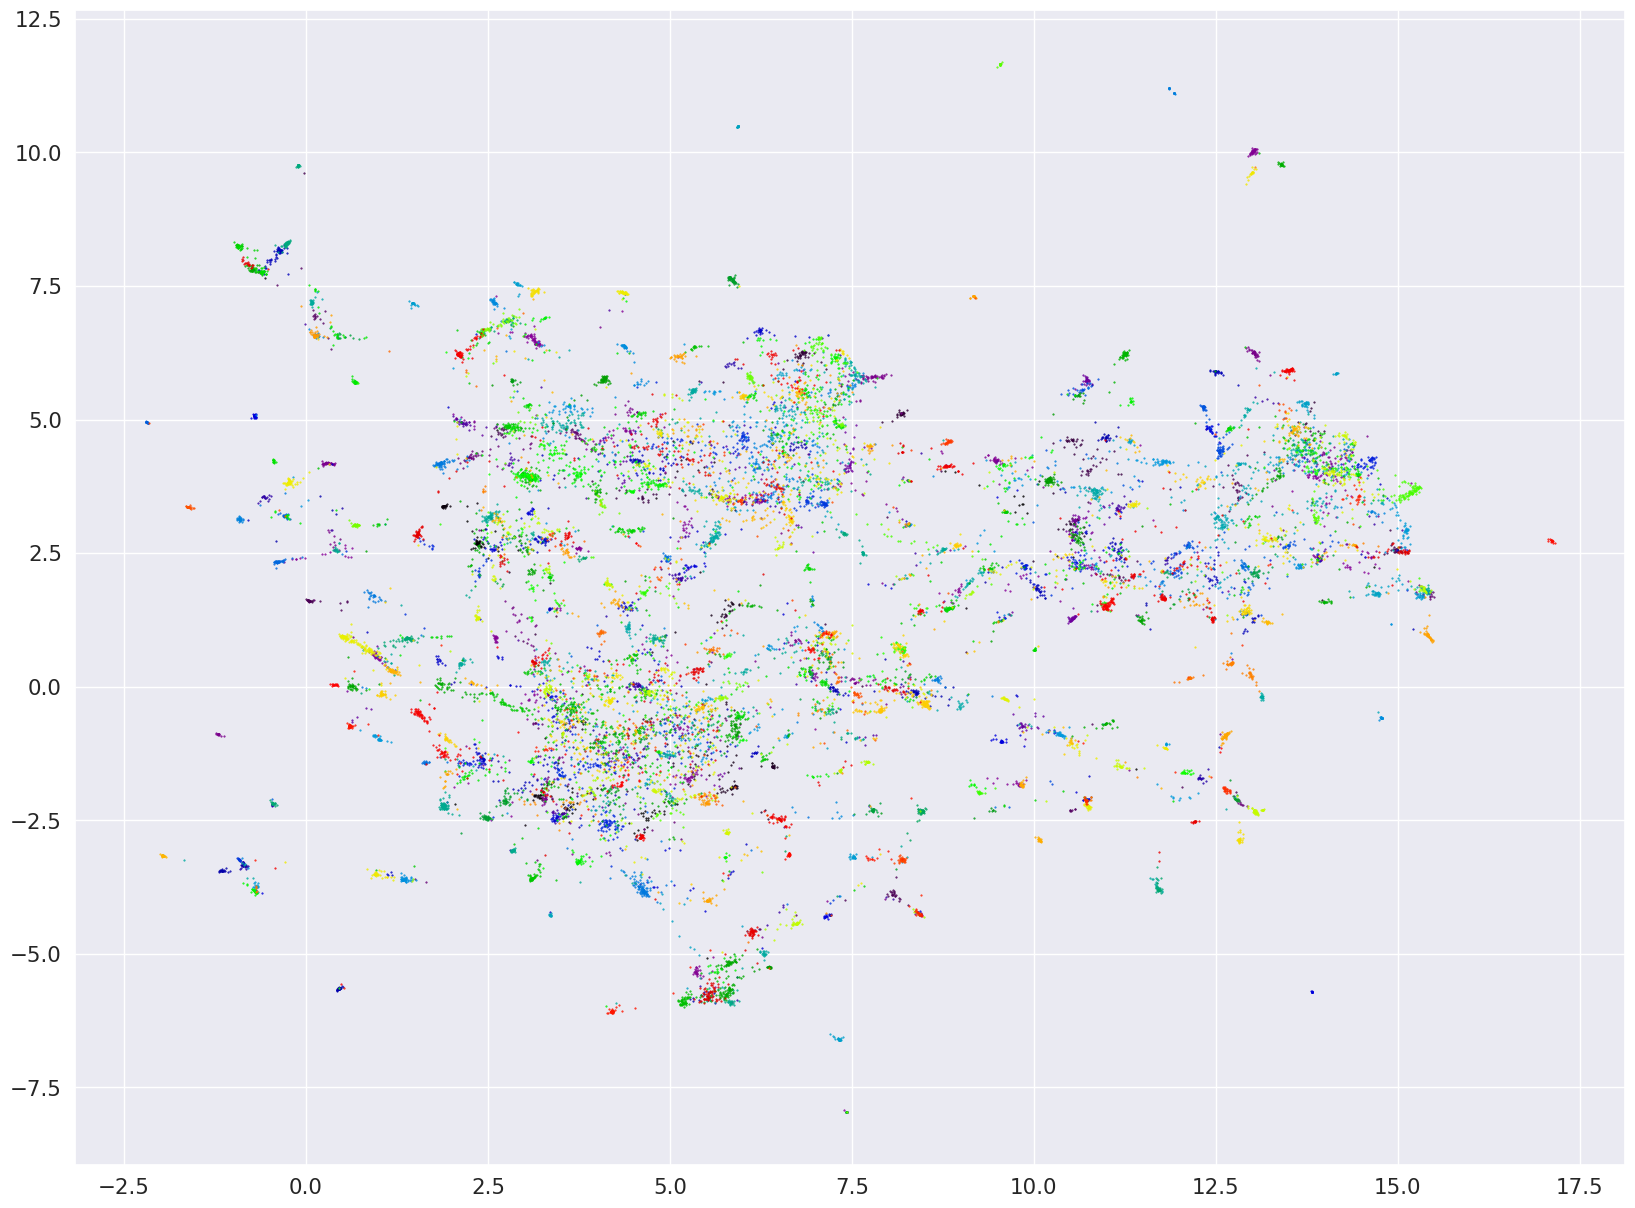

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=95
INFO:PML:embedding dimensionality is 1024
INFO:PML:running k-means clustering with k=748
INFO:PML:embedding dimensionality is 1024
WARNING clustering 17958 points to 748 centroids: please provide at least 29172 training points
INFO:PML:New best accuracy! 0.36891728057178663
INFO:PML:TRAINING EPOCH 10
total_loss=0.59966: 100%|███████████████████████████████████████████████████████████| 1028/1028 [05:53<00:00,  2.91it/s]
INFO:PML:Evaluating epoch 10
INFO:PML:Getting embeddings for the val split
100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:01<00:00,  9.14it/s]
INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


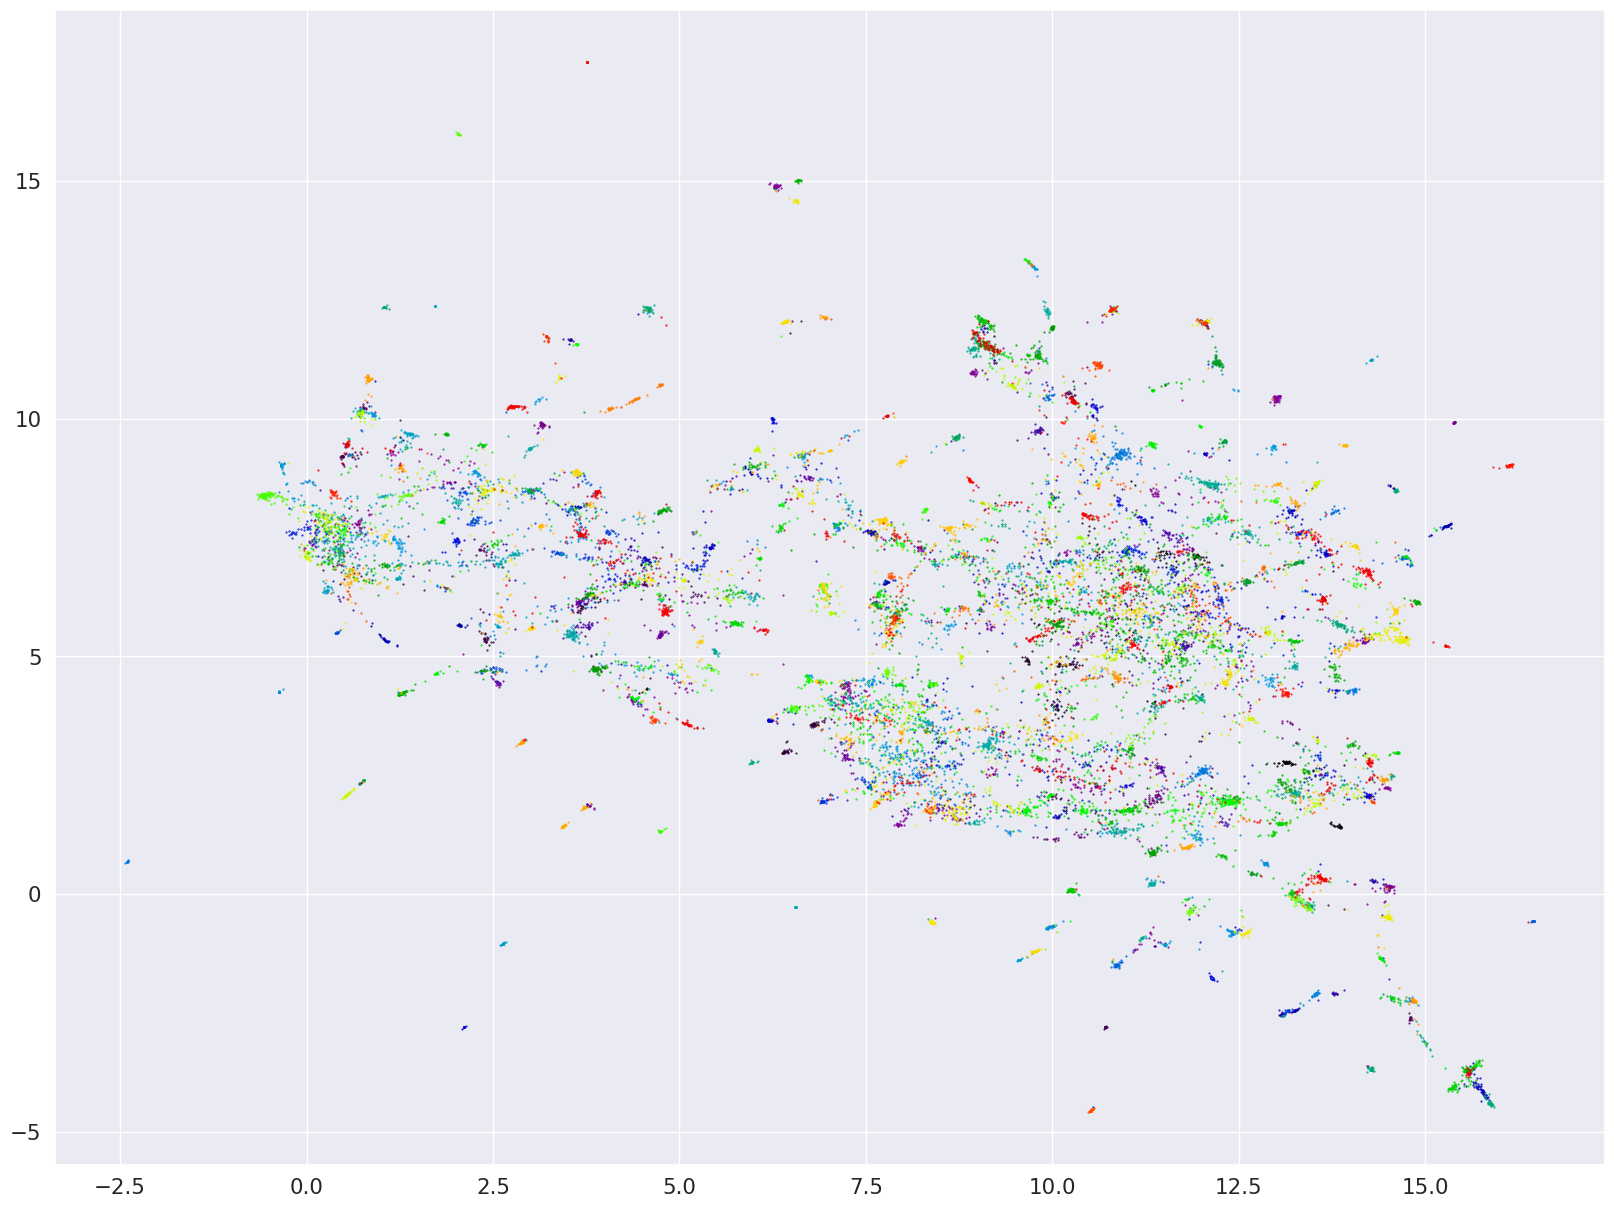

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=95
INFO:PML:embedding dimensionality is 1024
INFO:PML:running k-means clustering with k=748
INFO:PML:embedding dimensionality is 1024
WARNING clustering 17958 points to 748 centroids: please provide at least 29172 training points
INFO:PML:New best accuracy! 0.3748568614820393
INFO:PML:TRAINING EPOCH 11
total_loss=0.68062: 100%|███████████████████████████████████████████████████████████| 1028/1028 [05:53<00:00,  2.91it/s]
INFO:PML:Evaluating epoch 11
INFO:PML:Getting embeddings for the val split
100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:01<00:00,  9.12it/s]
INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


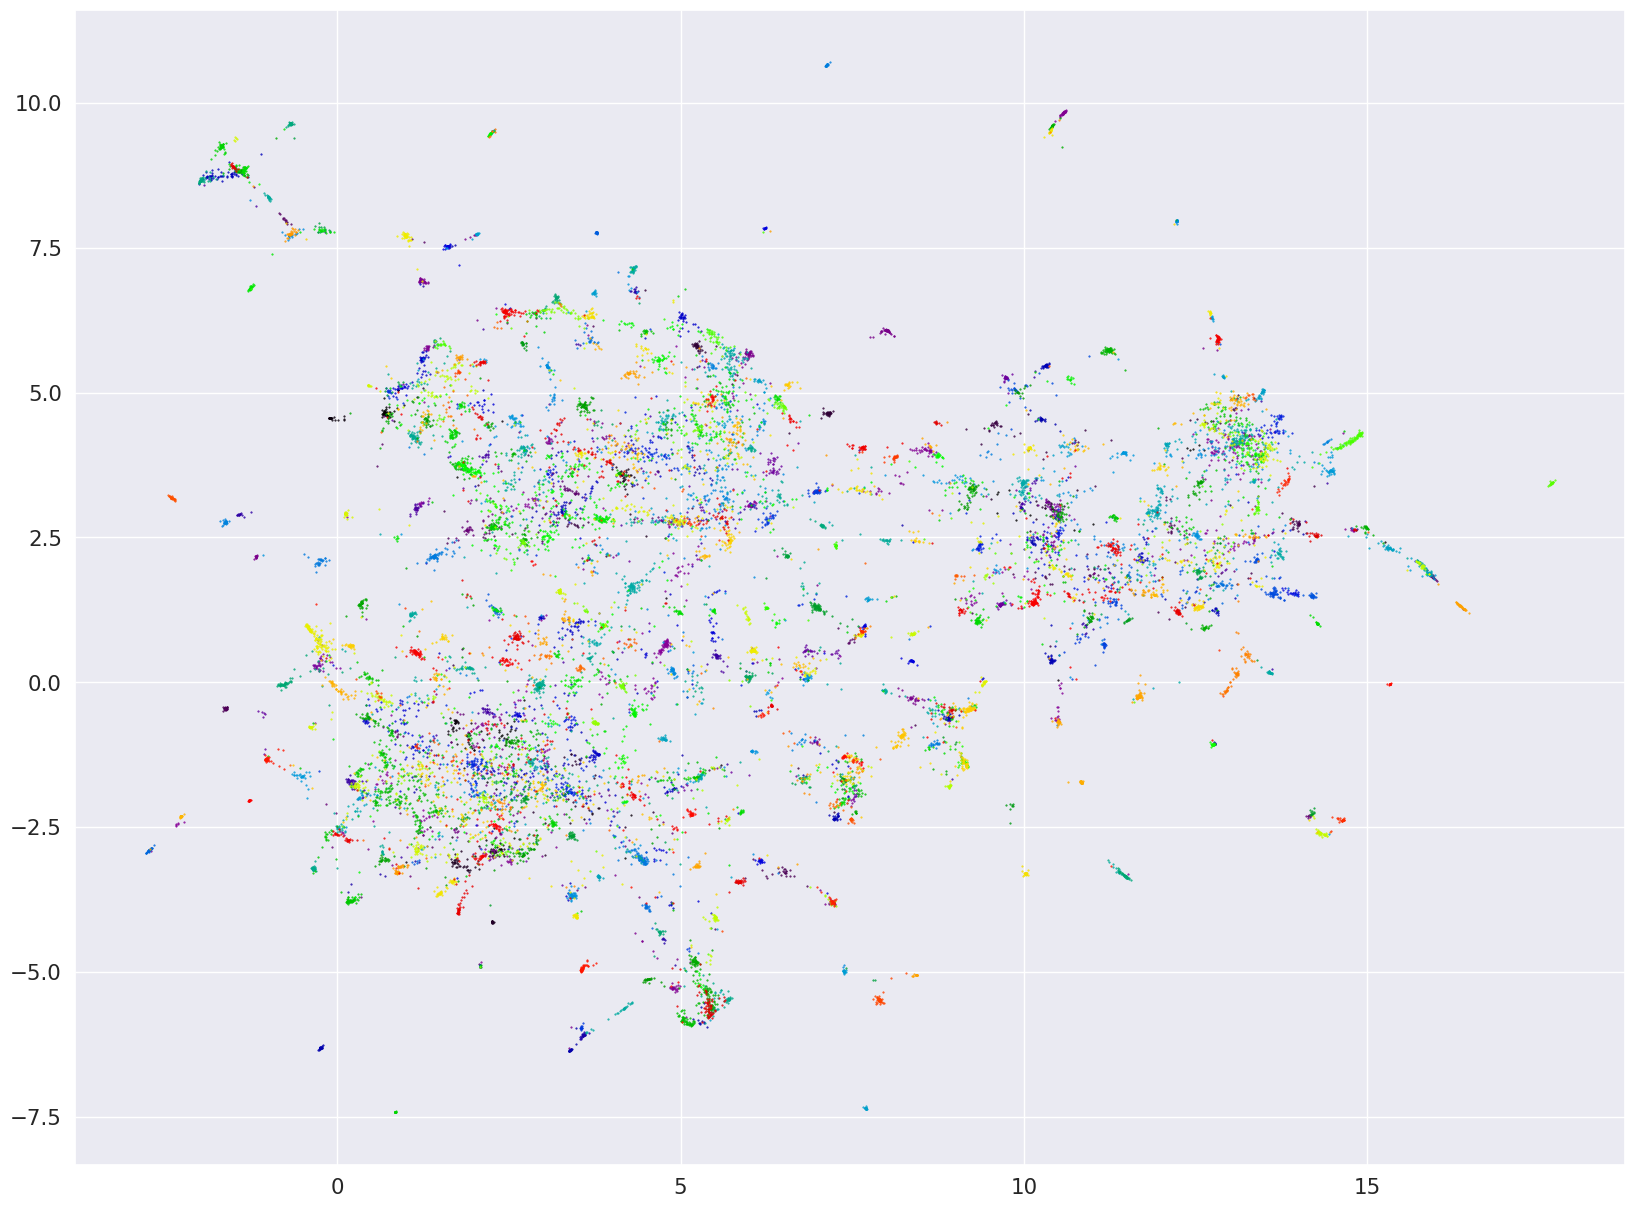

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=95
INFO:PML:embedding dimensionality is 1024
INFO:PML:running k-means clustering with k=748
INFO:PML:embedding dimensionality is 1024
WARNING clustering 17958 points to 748 centroids: please provide at least 29172 training points
INFO:PML:New best accuracy! 0.37798151012593695
INFO:PML:TRAINING EPOCH 12
total_loss=0.75528: 100%|███████████████████████████████████████████████████████████| 1028/1028 [05:53<00:00,  2.91it/s]
INFO:PML:Evaluating epoch 12
INFO:PML:Getting embeddings for the val split
100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:01<00:00,  9.14it/s]
INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


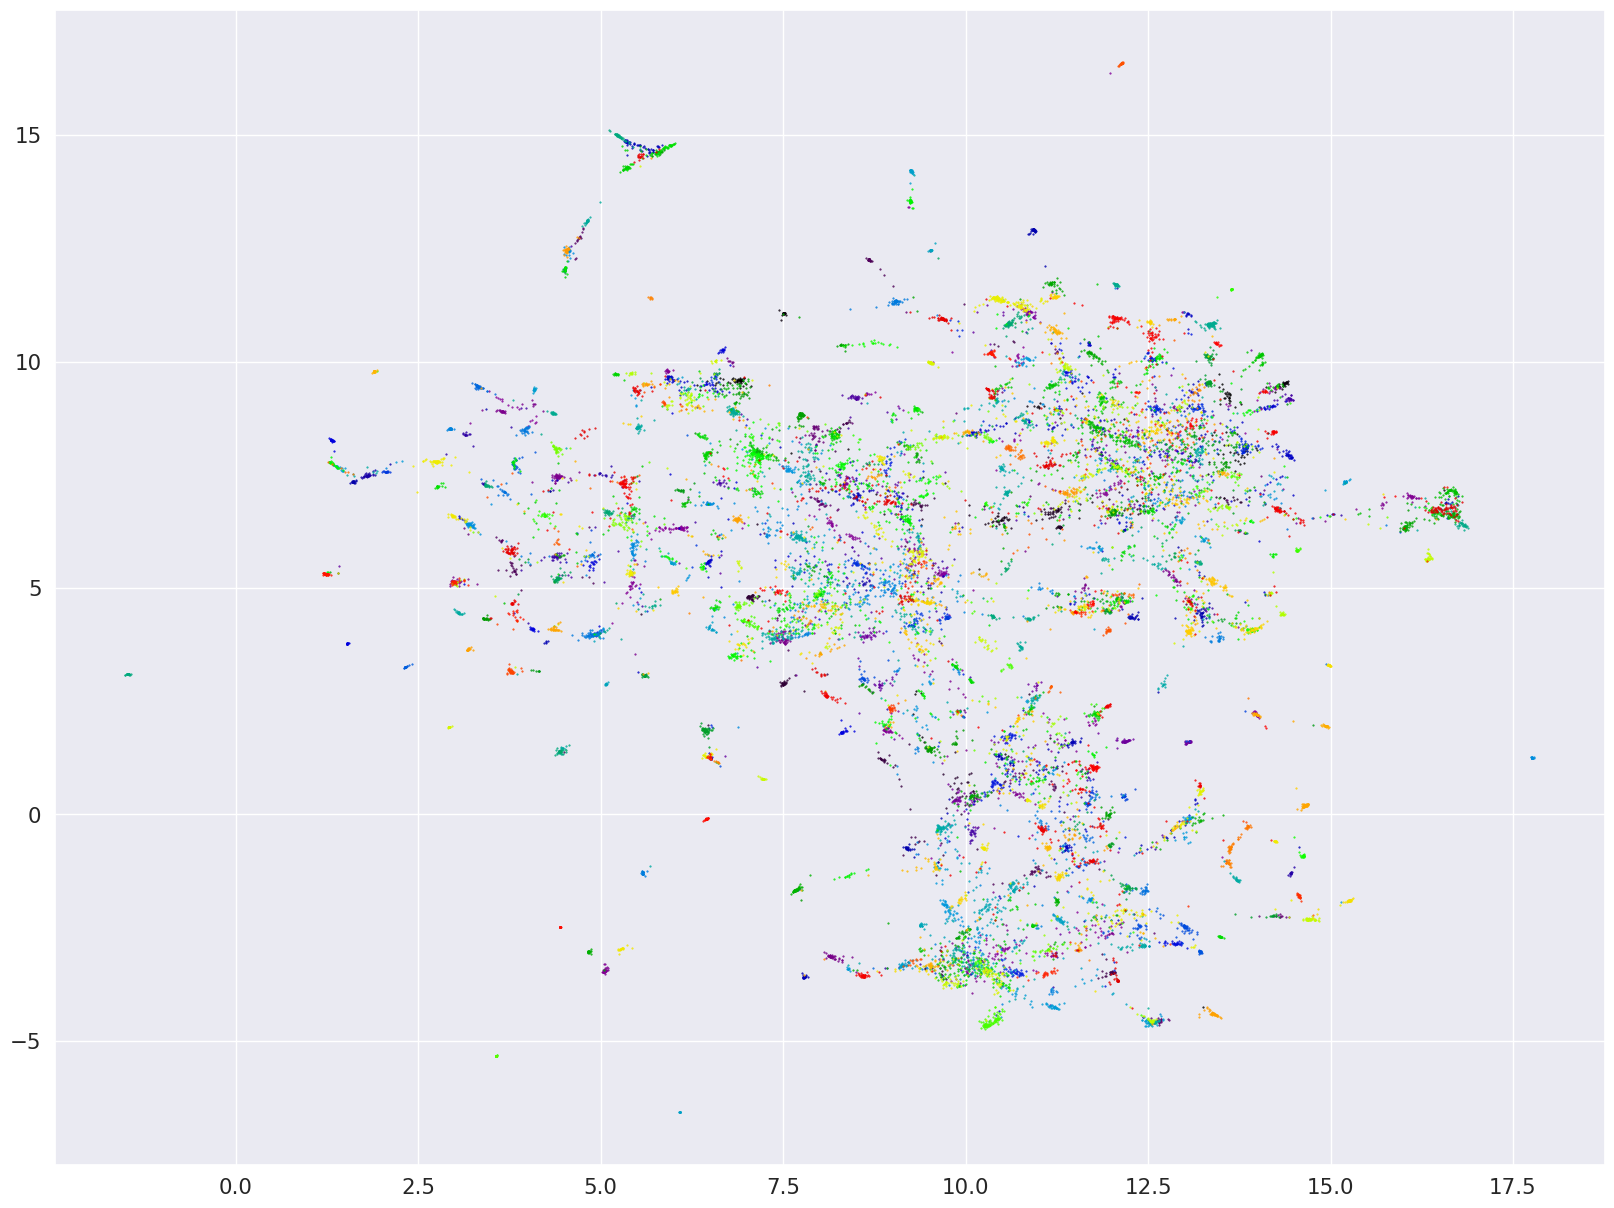

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=95
INFO:PML:embedding dimensionality is 1024
INFO:PML:running k-means clustering with k=748
INFO:PML:embedding dimensionality is 1024
WARNING clustering 17958 points to 748 centroids: please provide at least 29172 training points
INFO:PML:New best accuracy! 0.38407593364050624
INFO:PML:TRAINING EPOCH 13
total_loss=0.82413: 100%|███████████████████████████████████████████████████████████| 1028/1028 [05:53<00:00,  2.91it/s]
INFO:PML:Evaluating epoch 13
INFO:PML:Getting embeddings for the val split
100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:01<00:00,  9.13it/s]
INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


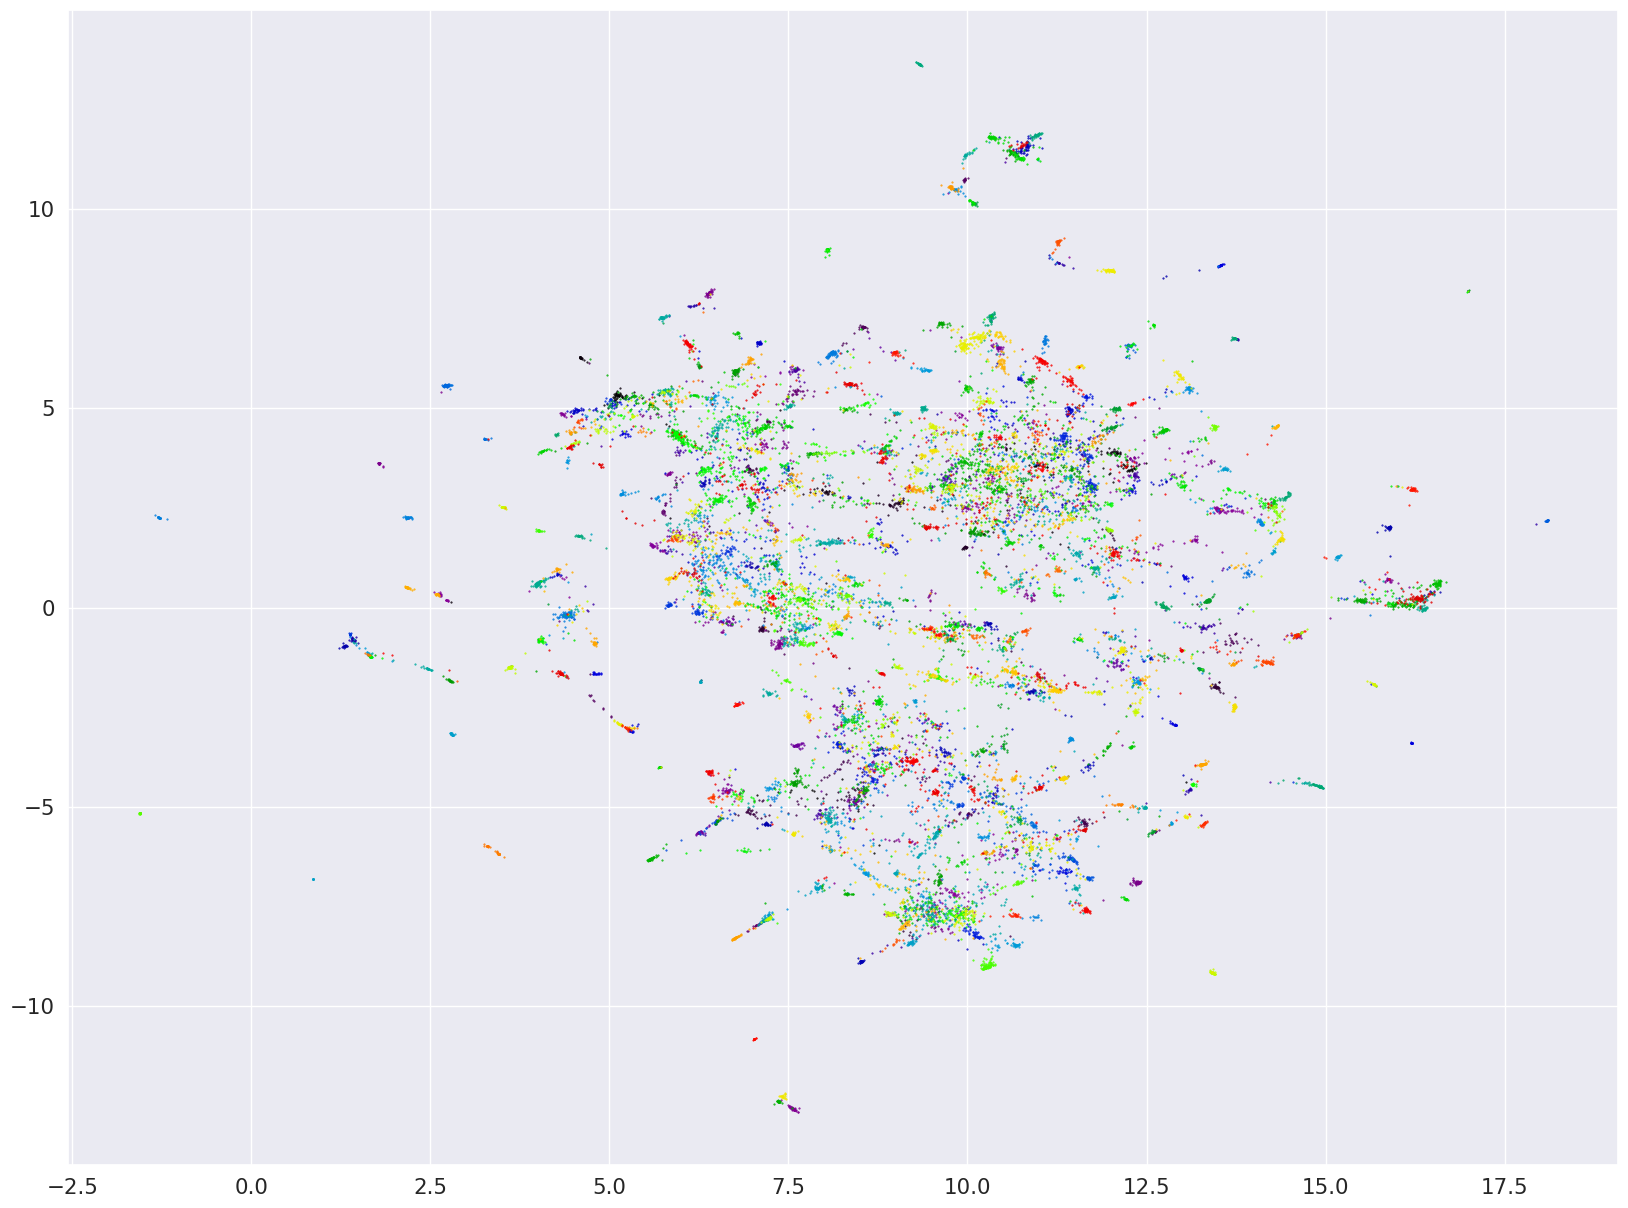

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=95
INFO:PML:embedding dimensionality is 1024
INFO:PML:running k-means clustering with k=748
INFO:PML:embedding dimensionality is 1024
WARNING clustering 17958 points to 748 centroids: please provide at least 29172 training points
INFO:PML:TRAINING EPOCH 14
total_loss=0.33292: 100%|███████████████████████████████████████████████████████████| 1028/1028 [05:53<00:00,  2.91it/s]
INFO:PML:Evaluating epoch 14
INFO:PML:Getting embeddings for the val split
100%|█████████████████████████████████████████████████████████████████████████████████| 562/562 [01:01<00:00,  9.16it/s]
INFO:PML:Running UMAP on the val set
INFO:PML:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


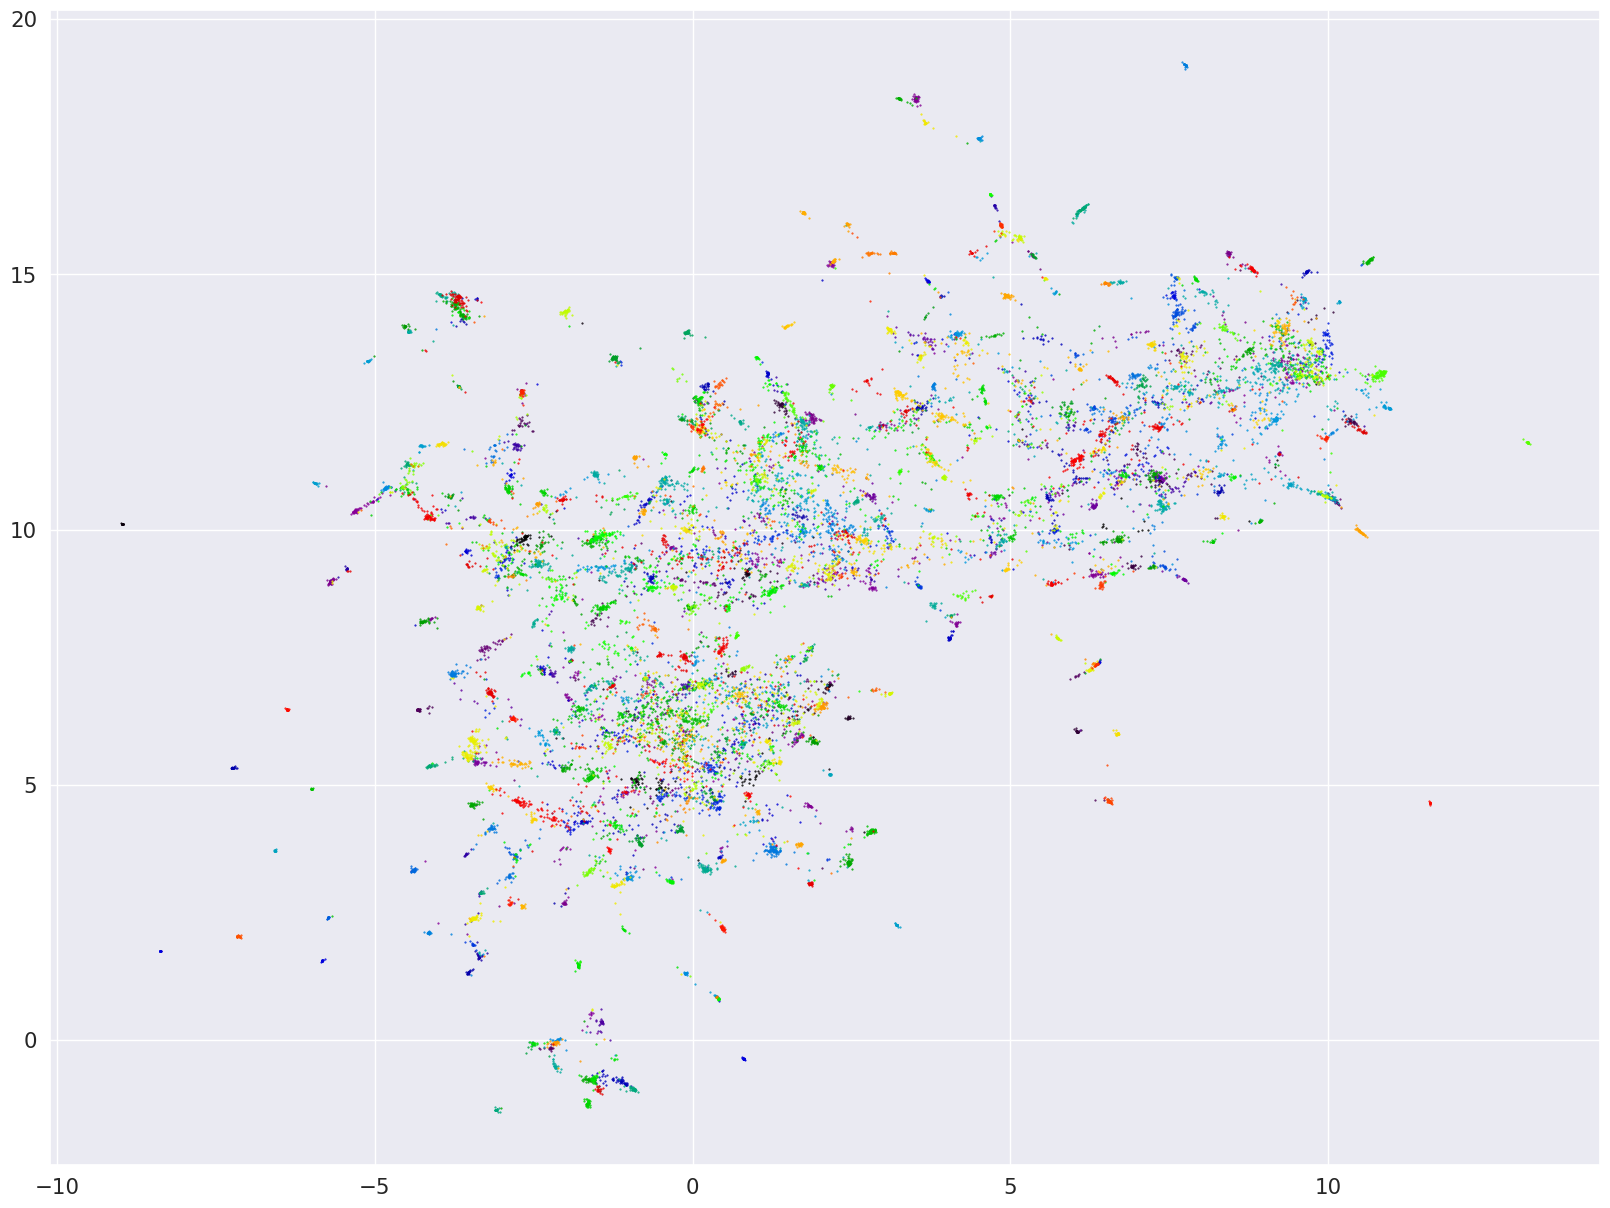

INFO:PML:Computing accuracy for the val split w.r.t ['val']
INFO:PML:running k-nn with k=95
INFO:PML:embedding dimensionality is 1024
INFO:PML:running k-means clustering with k=748
INFO:PML:embedding dimensionality is 1024
WARNING clustering 17958 points to 748 centroids: please provide at least 29172 training points
INFO:PML:New best accuracy! 0.38452176843733205


In [87]:
trainer.train(num_epochs=num_epochs)